In [1]:
import pickle as pkl
import pandas as pd
import xarray as xr
from pathlib import Path
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from neuralhydrology.evaluation.signatures import calculate_all_signatures

In [2]:
def load_pickle(path):
    with open(path, 'rb') as f:
        return pkl.load(f)

fdc_data = load_pickle("ENSEMBLE_FDC1_1607_223503.p")
nse_data = load_pickle("ENSEMBLE_NSE5_1707_042609.p")

In [3]:
def get_precip_file_path(basin_id, base_dir="/Users/jmframe/data/CAMELS_US/basin_mean_forcing/nldas") -> Path:
    file_name = f"{basin_id}_lump_nldas_forcing_leap.txt"
    base_path = Path(base_dir)

    for subdir in base_path.iterdir():
        if subdir.is_dir():
            candidate = subdir / file_name
            if candidate.exists():
                return candidate

    raise FileNotFoundError(f"Precip file for {basin_id} not found in any subdirectory of {base_dir}")

def load_precip_as_dataarray(path: Path) -> xr.DataArray:
    column_names = [
        'year', 'month', 'day', 'hour', 'dayl', 'prcp(mm/day)',
        'srad', 'swe', 'tmax', 'tmin', 'vp'
    ]
    
    df = pd.read_csv(
        path, 
        sep=r'\s+', 
        header=0, 
        skiprows=3, 
        names=column_names,
        engine='python'
    )
    
    dates = pd.to_datetime(df[['year', 'month', 'day']])
    prcp = df['prcp(mm/day)'].values
    
    return xr.DataArray(prcp, coords={'time': dates}, dims='time', name='precip')

In [4]:
obs_sig_dict = {}
sim_sig_dict_fdc = {}
sim_sig_dict_nse = {}

all_site_ids = set(fdc_data.keys()) & set(nse_data.keys())

for site_id in all_site_ids:
    try:
        ds_fdc = fdc_data[site_id]['1D']['xr']
        ds_nse = nse_data[site_id]['1D']['xr']

        obs = ds_fdc['QObs(mm/d)_obs'].squeeze('time_step').dropna('date')
        sim_fdc = ds_fdc['QObs(mm/d)_sim'].squeeze('time_step').sel(date=obs.date)
        sim_nse = ds_nse['QObs(mm/d)_sim'].squeeze('time_step').sel(date=obs.date)

        pr_path = get_precip_file_path(site_id)
        prcp = load_precip_as_dataarray(pr_path).sel(time=obs.date.values)

        # xarray wrapping
        obs_da = xr.DataArray(obs.values, coords={'time': obs.date.values}, dims='time').rename({'time': 'date'})
        sim_fdc_da = xr.DataArray(sim_fdc.values, coords={'time': obs.date.values}, dims='time').rename({'time': 'date'})
        sim_nse_da = xr.DataArray(sim_nse.values, coords={'time': obs.date.values}, dims='time').rename({'time': 'date'})
        prcp_da = xr.DataArray(prcp.values, coords={'time': prcp.time.values}, dims='time').rename({'time': 'date'})

        for da in [obs_da, sim_fdc_da, sim_nse_da, prcp_da]:
            da['date'] = pd.date_range(start=da['date'].values[0], periods=da.sizes['date'], freq='D')

        obs_sig_dict[site_id] = calculate_all_signatures(obs_da, prcp_da, datetime_coord="date")
        sim_sig_dict_fdc[site_id] = calculate_all_signatures(sim_fdc_da, prcp_da, datetime_coord="date")
        sim_sig_dict_nse[site_id] = calculate_all_signatures(sim_nse_da, prcp_da, datetime_coord="date")

    except Exception as e:
        print(f"Skipping {site_id}: {e}")

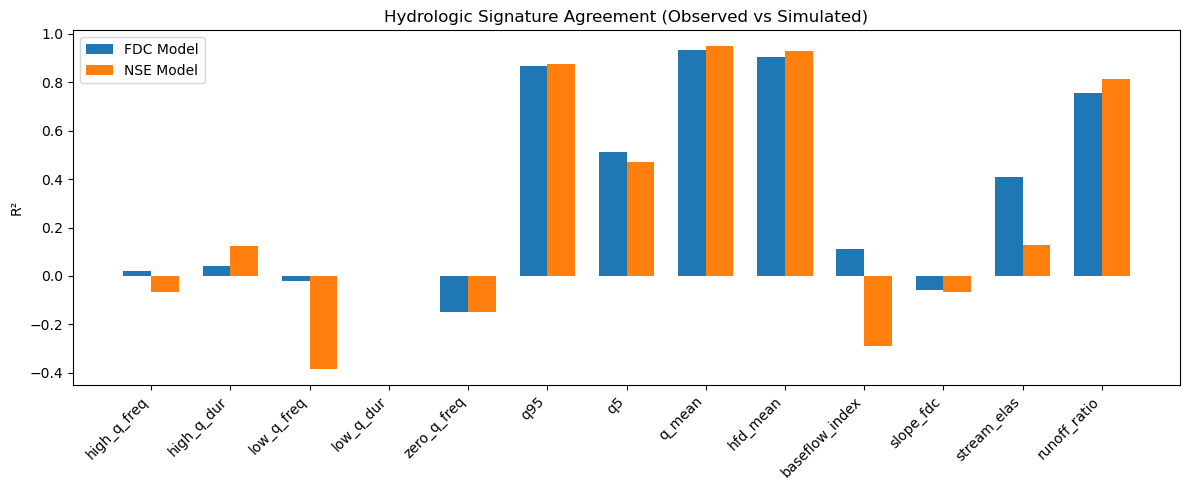

In [5]:
signatures = list(next(iter(obs_sig_dict.values())).keys())
r2_fdc = []
r2_nse = []

for sig in signatures:
    try:
        obs_vals = [obs_sig_dict[b][sig] for b in all_site_ids if sig in obs_sig_dict[b]]
        sim_vals_fdc = [sim_sig_dict_fdc[b][sig] for b in all_site_ids if sig in sim_sig_dict_fdc[b]]
        sim_vals_nse = [sim_sig_dict_nse[b][sig] for b in all_site_ids if sig in sim_sig_dict_nse[b]]

        r2_fdc.append(r2_score(obs_vals, sim_vals_fdc))
        r2_nse.append(r2_score(obs_vals, sim_vals_nse))
    except Exception:
        r2_fdc.append(float('nan'))
        r2_nse.append(float('nan'))

# Plot
import numpy as np
x = np.arange(len(signatures))
width = 0.35

plt.figure(figsize=(12, 5))
plt.bar(x - width/2, r2_fdc, width=width, label='FDC Model')
plt.bar(x + width/2, r2_nse, width=width, label='NSE Model')
plt.xticks(x, signatures, rotation=45, ha='right')
plt.ylabel('R²')
plt.title('Hydrologic Signature Agreement (Observed vs Simulated)')
plt.legend()
plt.tight_layout()
plt.show()